Q1 - Sample Discrete Distribution

In this Question, we will generate samples from a provided discrete distribution. We assume that dist[i] represents the probability of obtaining the value i

In [ ]:
import torch
import matplotlib

Initially, we need to verify the validity of the distribution.

In [ ]:
def is_valid_dist(dist):
  """
  Check if a given distribution is valid.

  A valid distribution is defined as follows:
  1. All elements are non-negative.
  2. The sum of all elements is equal to 1.

  Parameters:
  - dist (list or array-like): The distribution to be checked.

  Returns:
  - bool: True if the distribution is valid, False otherwise.
  """
  return torch.all(dist > 0) and (torch.sum(dist) == 1)

Next, after confirming the validity of the distribution, we proceed to sample from it based on the given distribution and the desired size of the output. We accomplish this by utilizing random numbers from a uniform distribution and their corresponding proportions within the cumulative distribution function (cdf) of the distribution.

In [ ]:
def my_sampler(size,dist,requires_grad=False):
  """
  Sample from a distribution.

  This function samples from a given distribution using the following algorithm:
  1. Calculate the cumulative distribution function (CDF) of the distribution.
  2. Generate random numbers from a uniform distribution in the range [0, 1].
  3. Determine which interval each random number falls into based on the CDF.

  Parameters:
    - size (int): The number of samples to generate.
    - dist (list or array-like): The distribution to sample from.
    - requires_grad (bool, optional): Whether to track gradients for the output tensor (default is False).

  Returns:
    - tensor: A tensor containing the sampled values.

  Raises:
    - ValueError: If the distribution is not valid (sum of elements != 1 or contains negative elements).

  """

  try:
    torch_dist = dist.clone().detach()
  except AttributeError:
    torch_dist = torch.tensor(dist).clone().detach()

  if not is_valid_dist(torch_dist):
    raise ValueError("Invalid distribution: sum of elements must be equal to 1 and all elements must be non-negative.")

  cdf = torch.cumsum(torch_dist, 0) # Calculate cdf of the distribution
  U = torch.rand(size, requires_grad=False) # randomize size elements in range 0-1

  available = torch.ones(size, dtype=bool)  # mask to keep track of available indices
  out = torch.zeros(size, dtype=torch.float64)  # Initialize output tensor
  for i in range(len(dist)-1):
    mask = torch.logical_and(available, U<cdf[i]) # Identify which elements fall below the cdf value
    out[mask] = i  # Assign current index in the suitable indices
    available[mask] = False  # Update the availability mask for the assigned indices



  out[available] = i+1 # The available elements correspond to the last element of the distribution.
  out.requires_grad_(requires_grad) # Track gradients if required
  return out


Usage example:

In [ ]:
my_sampler(10,[0.5,0.5])

tensor([0., 0., 0., 1., 0., 0., 0., 1., 1., 0.], dtype=torch.float64)

In [ ]:
A=my_sampler((2,8),[0.1,0.2,0.7],requires_grad=True)
print(A,A.grad,sep='\n')


tensor([[2., 2., 2., 1., 0., 2., 2., 0.],
        [2., 2., 2., 2., 2., 2., 2., 0.]], dtype=torch.float64,
       requires_grad=True)
None


Let's sample a relatively large number of values from a distribution and observe the outcomes

In [ ]:
dist_b = torch.tensor([0.1, 0.2 , 0.7]);
a = my_sampler(10000 ,dist_b);

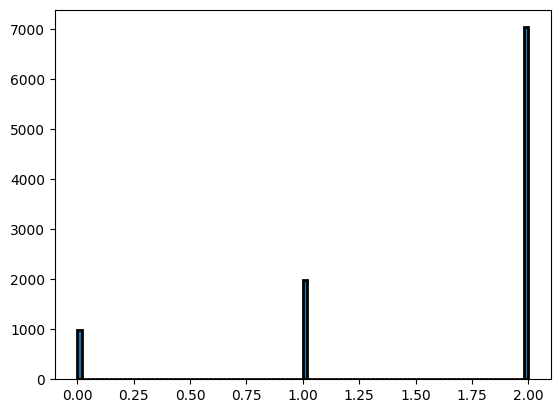

In [ ]:
matplotlib.pyplot.hist(a, 100, linewidth=2, edgecolor='black' );


As depicted in the histogram, we observe that the sampled numbers closely match the original distribution, as anticipated when sampling a large quantity of numbers.

Q2 - Auto Grad

In this notebook, we aim to develop a system similar to PyTorch's auto-gradient feature. To achieve this, we'll introduce a new class that stores both the numerical value and its corresponding gradient. Additionally, we'll implement several mathematical functions. These functions will accept an instance of our new class as input and return the result of the mathematical operation along with its immediate gradient to keep track of gradients.

In [ ]:
import math

Initially, we'll establish the class definition

In [ ]:
class MyScalar:
    """
    A class representing a scalar value with its immediate gradient and parent scalar.

    Attributes:
        imediate_value (float): The numerical value of the scalar.
        imediate_derivative (float): The immediate gradient relative to its parent scalar, if exists.
        father (MyScalar): The parent scalar from which this scalar is derived.
    """

    def __init__(self, imediate_value, imediate_derivative=1.0, father=None):
        """
        Initializes a MyScalar object.

        Args:
            imediate_value (float): The numerical value of the scalar.
            imediate_derivative (float, optional): The immediate gradient relative to its parent scalar.
            father (MyScalar, optional): The parent scalar from which this scalar is derived.
        """
        self.imediate_value = float(imediate_value)
        self.imediate_derivative = float(imediate_derivative)
        self.father = father

    def get_father(self):
        """
        Gets the parent scalar of this MyScalar object.

        Returns:
            MyScalar or None: The parent scalar if it exists, otherwise None.
        """
        return self.father

    def __str__(self):
        """
        Returns a string representation of the MyScalar object.

        Returns:
            str: A string containing the value, immediate derivative, and information about the parent.
        """
        father_str = "father_id = " + str(id(self.father)) if self.father is not None else "Father is None"
        return f"Scalar value = {self.imediate_value}, immediate derivative = {self.imediate_derivative}, {father_str}"


Next, we'll proceed to implement fundamental mathematical operations using this class.

In [ ]:
def multiply(scalar, times):
    """
    Multiplies a MyScalar object by a scalar value.

    Args:
        times (float): The scalar value to multiply by.

    Returns:
        MyScalar: The result of the multiplication.
    """
    other = MyScalar(scalar.imediate_value * times, times, scalar)
    return other

def power(scalar, pow):
    """
    Raises a MyScalar object to a power.

    Args:
        pow (float): The power to raise the scalar value to.

    Returns:
        MyScalar: The result of raising to the power.
    """
    other = MyScalar(scalar.imediate_value ** pow, pow * (scalar.imediate_value ** (pow - 1)), scalar)
    return other

def add_int(scalar, some_int):
    """
    Adds an integer to a MyScalar object.

    Args:
        some_int (int): The integer to add.

    Returns:
        MyScalar: The result of the addition.
    """
    other = MyScalar(scalar.imediate_value + some_int, 1.0, scalar)
    return other

def cos(scalar):
    """
    Computes the cosine of a MyScalar object.

    Returns:
        MyScalar: The result of computing the cosine.
    """
    other = MyScalar(math.cos(scalar.imediate_value), -1 * math.sin(scalar.imediate_value), scalar)
    return other

def sin(scalar):
    """
    Computes the sine of a MyScalar object.

    Returns:
        MyScalar: The result of computing the sine.
    """
    other = MyScalar(math.sin(scalar.imediate_value), math.cos(scalar.imediate_value), scalar)
    return other

def ln(scalar):
    """
    Computes the natural logarithm of a MyScalar object.

    Returns:
        MyScalar: The result of computing the natural logarithm.
    """
    other = MyScalar(math.log(scalar.imediate_value), 1 / scalar.imediate_value, scalar)
    return other

def exp(scalar):
    """
    Computes the exponential of a MyScalar object.

    Returns:
        MyScalar: The result of computing the exponential.
    """
    other = MyScalar(math.exp(scalar.imediate_value), math.exp(scalar.imediate_value), scalar)
    return other

Lastly, there may be a requirement to retrieve the gradients of an instance of this class relative to all its ancestors

In [ ]:
def get_gradient(s_scalar):
  """
  Calculates the derivatives of a MyScalar object relative to all of its ancestors.

  Args:
      s_scalar (MyScalar): The MyScalar object for which to compute derivatives.

  Returns:
      dict: A dictionary containing the derivatives relative to all ancestors, where keys are the IDs of MyScalar objects
          and values are the corresponding derivatives.
  """
  gradient_dict = {}
  if s_scalar.get_father() is None: # If the scalar has no parent, its derivative with respect to itself is 1.0
    gradient_dict[id(s_scalar)] = 1.0
    return gradient_dict

  # Recursively calculate derivatives for parent scalars
  father_gradients = get_gradient(s_scalar.father)

  # Calculate derivatives for current scalar relative to its ancestors
  for dependent_scalar_id in father_gradients.keys():
    correction = s_scalar.imediate_derivative * father_gradients[dependent_scalar_id]  # Using chain rule, derivative relative to the current ancestor
    gradient_dict[dependent_scalar_id] = correction

  gradient_dict[id(s_scalar)] = 1.0 # Calculate derivatives for current scalar relative to its ancestors
  return gradient_dict


Let's create a simple instance of this class as an example

In [ ]:
a=MyScalar(2) # Creating a scalar using MyScalar class with value=2
print(f"Example scalar using constructor:")
print(a)

Example scalar using constructor:
Scalar value = 2.0, immediate derivative = 1.0, Father is None


Let's examine some instances that result from mathematical operations applied to instances of this class, as demonstrated earlier

In [ ]:
# Create some scalars from MyScalar class that are a result of mathematics operations on others scalars
b=power(a,3) # b = a^3 -- > value = 2^3 = 8,   imediate derivative = db/da = 3*(a^2) = [a=2] = 12
print(f"b = {b}")

c=multiply(b,3) # c = 3*b =3*(a^3) -- > value = 3 * 2^3 = 24, imediate derivative = dc/db = 3
print(f"c = {c}")

d = add_int(a, 9) # d = a + 9 -- > value = 2 + 9 = 11, imediate derivative = dd/da = 1
print(f"d = {d}")

b = Scalar value = 8.0, immediate derivative = 12.0, father_id = 140057812448400
c = Scalar value = 24.0, immediate derivative = 3.0, father_id = 140057812443600
d = Scalar value = 11.0, immediate derivative = 1.0, father_id = 140057812448400


Now, let's restore the gradients for these instances

In [ ]:
a_grad = get_gradient(a) # da/da = 1
b_grad = get_gradient(b) # db/db = 1, db/da = 12
c_grad = get_gradient(c) # dc/dc = 1, dc/db = 3, dc/da = 9*(a^2) = 36
d_grad = get_gradient(d) # dd/dd = 1, dd/da = 1
print(f"a gradient: {a_grad}")
print(f"b gradient: {b_grad}")
print(f"c gradient: {c_grad}")
print(f"d gradient: {d_grad}")


a gradient: {140057812448400: 1.0}
b gradient: {140057812448400: 12.0, 140057812443600: 1.0}
c gradient: {140057812448400: 36.0, 140057812443600: 3.0, 140057812439040: 1.0}
d gradient: {140057812448400: 1.0, 140057812442976: 1.0}


It's evident that the gradients relative to each of their ancestors were correctly calculated for each of the instances

Let's explore more examples using other mathematical operations:

In [ ]:
# Additional Examples Utilizing Other Mathematical Functions Defined for MyScalar
s1 = MyScalar(math.pi/2.0)
s2 = MyScalar(1)

e = cos(s1) # e = cos(s1) -- > value = cos(pi/2) = 0, imediate derivative = de/ds1 = -sin(s1) = -1
f = sin(s1) # f = sin(s1) -- > value = sin(pi/2) = 1, imediate derivative = df/ds1 = cos(s1) = 0
g = ln(s2)  # g = ln(s2) -- > value = ln(1) = 0, imediate derivative = dg/ds2 = 1/s2 = 1
h = exp(s2) # h = exp(s2) -- > value = exp(1) = e, imediate derivative = dh/ds2 = h = e
print(f"e: {e}")
print(f"f: {f}")
print(f"g: {g}")
print(f"h: {h}")

e: Scalar value = 6.123233995736766e-17, immediate derivative = -1.0, father_id = 140057812439568
f: Scalar value = 1.0, immediate derivative = 6.123233995736766e-17, father_id = 140057812439568
g: Scalar value = 0.0, immediate derivative = 1.0, father_id = 140057812447872
h: Scalar value = 2.718281828459045, immediate derivative = 2.718281828459045, father_id = 140057812447872


Now, let's restore the gradients:

In [ ]:
e_grad = get_gradient(e) # de/de = 1, de/ds1 = -1
f_grad = get_gradient(f) # df/df = 1, df/ds1 = 0
g_grad = get_gradient(g) # dg/dg = 1, dg/ds2 = 1
h_grad = get_gradient(h) # dh/dh = 1, dh/ds2 = e

print(f"e gradient: {e_grad}")
print(f"f gradient: {f_grad}")
print(f"g gradient: {g_grad}")
print(f"h gradient: {h_grad}")

e gradient: {140057812439568: -1.0, 140057812442688: 1.0}
f gradient: {140057812439568: 6.123233995736766e-17, 140057812447008: 1.0}
g gradient: {140057812447872: 1.0, 140057812441296: 1.0}
h gradient: {140057812447872: 2.718281828459045, 140057812446144: 1.0}


We can see that the gradients relative to each of their ancestors were accurately calculated for each of the instances here as well.